In [0]:
# load file paths and constants

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

PATH = "/content/drive/My Drive/"
file_path = "/content/drive/My Drive/book_cover_data/title30/title30cat_2.zip"
csv_path = "/content/drive/My Drive/book_cover_data/title30/book30short.csv"
cover_path = "/content/224x224/"
val_ratio = 0.1
test_ratio = 0.1
BUFFER_SIZE = 1000
BATCH_SIZE = 32
steps_train = (57000*0.8) // BATCH_SIZE
steps_val = (57000*0.1) // BATCH_SIZE
steps_test = (57000*0.1) // BATCH_SIZE
IMG_DIM = (128, 128, 3)
outdim_size = 30
vocab_size = 17997
max_len = 100

# write tfrecord for train, test and val
tfrecord_path = ["train_data.tfrecord", "val_data.tfrecord", "test_data.tfrecord"]


def unzip_data(file_path):
  from zipfile import ZipFile
  with ZipFile(file_path, "r") as zip:
    zip.extractall()
    return "Data has been extracted"

unzip_data(file_path)

2.2.0


In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# helper functions for writing tfrecord data
def load_csv():
    df = pd.read_csv(csv_path, header = 0, index_col = 0, encoding='latin1')

    # split the data into train, validation and test
    train_data, val_data = train_test_split(df, test_size=(test_ratio+val_ratio), random_state=21)
    val_data, test_data = train_test_split(val_data, test_size=test_ratio/(test_ratio+val_ratio), random_state=21)

    return train_data, val_data, test_data


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# functions for process texts
def get_token(texts, word_freq=5):
  words = texts.str.split(expand=True).stack().value_counts()
  words = pd.DataFrame(words, columns=["freq"])
  vocab_size = len(words[words.freq > word_freq])
  token = Tokenizer(num_words=vocab_size)
  token.fit_on_texts(texts)
  return token, vocab_size

def get_text_sequence(text, token, max_len=100):
  sequences = token.texts_to_sequences([text])
  return pad_sequences(sequences,maxlen=max_len).reshape(-1)

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def make_example(text_sequence, label, keras_hub=True):
    if keras_hub:
        feature = {            
            'text_sequence': _bytes_feature(text_sequence.encode()),
            'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
        }
    else:
        feature = {
              'text_sequence': tf.train.Feature(int64_list=tf.train.Int64List(value=text_sequence)),
              'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
          }
        
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecord(data, token, tfrecord_path, keras_hub=True):
    with tf.io.TFRecordWriter(tfrecord_path) as writer:
        for _,row in data.iterrows():
            text_sequence = row["text"] if keras_hub else get_text_sequence(row["text"], token)
            label = row["cat_id"]
            example = make_example(text_sequence, label, keras_hub)  
            writer.write(example.SerializeToString()) 

# healper functions for reading tfrecord data 
feature_description = {
    'text_sequence': tf.io.FixedLenFeature([100], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
}
feature_description_hub = {
    'text_sequence': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}


def parser(proto):
    parsed_features = tf.io.parse_single_example(proto, feature_description)
    text_sequence = parsed_features['text_sequence']
    label = parsed_features['label']
    return text_sequence, label

def parser_hub(proto):
    parsed_features = tf.io.parse_single_example(proto, feature_description_hub)
    text_sequence = parsed_features['text_sequence']
    label = parsed_features['label']
    return text_sequence, label

def get_dataset(tfrecord_path, keras_hub=True):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    if keras_hub:
        dataset = dataset.map(parser_hub, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    else:
        dataset = dataset.map(parser, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


def load_data(first_time=True, keras_hub=True):
    if first_time:
        data = load_csv()
        token, _ = get_token(data[0].text)
        for i in range(3):
           write_tfrecord(data[i], token, tfrecord_path[i], keras_hub)

    # load the dataset    
    dataset = []   
    for i in range(3):
        data = get_dataset(tfrecord_path[i], keras_hub)
        dataset.append(data)
    return dataset


In [0]:
train_data, val_data, test_data = load_data(True, True)

In [0]:
import matplotlib.pyplot as plt

def train_model(model, epoch_num):

    earlystop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2)
    checkpointer = callbacks.ModelCheckpoint(filepath="temp_weights.h5", verbose=1, save_best_only=True, save_weights_only=True)
  
    history = model.fit(train_data.repeat(),
                        steps_per_epoch = steps_train,
                        epochs = epoch_num,
                        validation_data= val_data.repeat(),
                        validation_steps = steps_val,
                        use_multiprocessing=True,
                        callbacks=[checkpointer, earlystop])


    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


    model.load_weights("temp_weights.h5")
    results = model.evaluate(val_data, use_multiprocessing=True, verbose=1)
    results = dict(zip(model.metrics_names, results))
    print('Result on validation data: ', results)

    results = model.evaluate(test_data, use_multiprocessing=True, verbose=1)
    results = dict(zip(model.metrics_names, results))
    print('Result on test data: ', results)


    return model

In [0]:
from tensorflow.keras import layers, applications, models, optimizers, losses, metrics, regularizers, callbacks

INIT_LR = 0.001
FINAL_LR = 1e-6
LR_DECAY = (1./(FINAL_LR/INIT_LR) -1)/steps_train
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

optimizer = optimizers.Adam(learning_rate=0.0001)
loss=losses.sparse_categorical_crossentropy
metric = ['accuracy', get_lr_metric(optimizer), tf.keras.metrics.SparseTopKCategoricalAccuracy(3)]

LSTM

In [0]:
model_lstm = models.Sequential()
model_lstm.add(layers.Input(shape=max_len))
model_lstm.add(layers.Embedding(vocab_size, max_len))
model_lstm.add(layers.LSTM(256))
model_lstm.add(layers.Dense(outdim_size, activation='softmax'))
model_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1799700   
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_5 (Dense)              (None, 30)                7710      
Total params: 2,172,978
Trainable params: 2,172,978
Non-trainable params: 0
_________________________________________________________________


Epoch 1/25
1424/1425 [============================>.] - ETA: 0s - loss: 3.1720 - accuracy: 0.0999 - lr: 1.0000e-04 - sparse_top_k_categorical_accuracy: 0.2245
Epoch 00001: val_loss improved from inf to 2.89137, saving model to temp_weights.h5
1425/1425 [==============================] - 38s 27ms/step - loss: 3.1719 - accuracy: 0.1000 - lr: 1.0000e-04 - sparse_top_k_categorical_accuracy: 0.2246 - val_loss: 2.8914 - val_accuracy: 0.1645 - val_lr: 1.0000e-04 - val_sparse_top_k_categorical_accuracy: 0.3250
Epoch 2/25
1423/1425 [============================>.] - ETA: 0s - loss: 2.7221 - accuracy: 0.1967 - lr: 1.0000e-04 - sparse_top_k_categorical_accuracy: 0.3974
Epoch 00002: val_loss improved from 2.89137 to 2.63068, saving model to temp_weights.h5
1425/1425 [==============================] - 37s 26ms/step - loss: 2.7219 - accuracy: 0.1967 - lr: 1.0000e-04 - sparse_top_k_categorical_accuracy: 0.3975 - val_loss: 2.6307 - val_accuracy: 0.2216 - val_lr: 1.0000e-04 - val_sparse_top_k_categoric

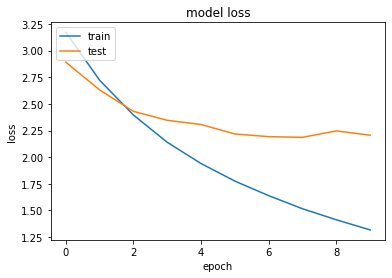

sequential_5
178/178 [==============================] - 1s 5ms/step - loss: 2.1862 - accuracy: 0.4001 - lr: 1.0000e-04 - sparse_top_k_categorical_accuracy: 0.6206
Result on validation data:  {'loss': 2.186213493347168, 'accuracy': 0.4001053273677826, 'lr': 9.999987378250808e-05, 'sparse_top_k_categorical_accuracy': 0.6206109523773193}
178/178 [==============================] - 1s 5ms/step - loss: 2.1796 - accuracy: 0.4149 - lr: 1.0000e-04 - sparse_top_k_categorical_accuracy: 0.6152
Result on test data:  {'loss': 2.179569721221924, 'accuracy': 0.4148525297641754, 'lr': 9.999987378250808e-05, 'sparse_top_k_categorical_accuracy': 0.6151685118675232}


In [0]:
train_model(model_lstm, 25)

Universal Sentence Decoder

In [0]:
from tensorflow.keras import layers, applications, models, optimizers, losses, metrics, regularizers, callbacks
import tensorflow_hub as hub

# constant for model compile
loss_fn = losses.sparse_categorical_crossentropy
optimizer_fn = optimizers.RMSprop(learning_rate=0.0001)
metric_ls = ["accuracy", tf.keras.metrics.SparseTopKCategoricalAccuracy(3)]

def build_hubnet_text(text_base, trainable=False):
    model = models.Sequential()
    model.add(hub.KerasLayer(text_base, input_shape=[], dtype=tf.string, trainable=trainable))
    model.add(layers.Dense(outdim_size, activation="softmax"))

    model.compile(loss=loss_fn, optimizer=optimizer_fn, metrics=metric_ls)

    return model



Epoch 1/25
1425/1425 [==============================] - ETA: 0s - loss: 3.3291 - accuracy: 0.2011 - sparse_top_k_categorical_accuracy: 0.3731
Epoch 00001: val_loss improved from inf to 3.25353, saving model to temp_weights.h5
1425/1425 [==============================] - 69s 48ms/step - loss: 3.3291 - accuracy: 0.2011 - sparse_top_k_categorical_accuracy: 0.3731 - val_loss: 3.2535 - val_accuracy: 0.3418 - val_sparse_top_k_categorical_accuracy: 0.5567
Epoch 2/25
1425/1425 [==============================] - ETA: 0s - loss: 3.1846 - accuracy: 0.3906 - sparse_top_k_categorical_accuracy: 0.6107
Epoch 00002: val_loss improved from 3.25353 to 3.11438, saving model to temp_weights.h5
1425/1425 [==============================] - 63s 44ms/step - loss: 3.1846 - accuracy: 0.3906 - sparse_top_k_categorical_accuracy: 0.6107 - val_loss: 3.1144 - val_accuracy: 0.4189 - val_sparse_top_k_categorical_accuracy: 0.6419
Epoch 3/25
1425/1425 [==============================] - ETA: 0s - loss: 3.0506 - accuracy:

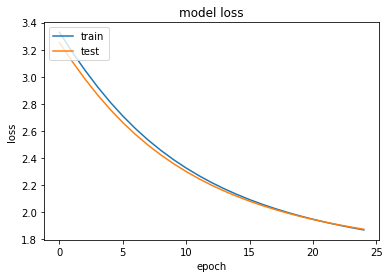

178/178 [==============================] - 7s 37ms/step - loss: 1.8737 - accuracy: 0.5279 - sparse_top_k_categorical_accuracy: 0.7421
Result on validation data:  {'loss': 1.873724102973938, 'accuracy': 0.5279143452644348, 'sparse_top_k_categorical_accuracy': 0.7420997023582458}
178/178 [==============================] - 7s 37ms/step - loss: 1.8755 - accuracy: 0.5258 - sparse_top_k_categorical_accuracy: 0.7370
Result on test data:  {'loss': 1.8754701614379883, 'accuracy': 0.5258075594902039, 'sparse_top_k_categorical_accuracy': 0.7370084524154663}


In [0]:
model = build_hubnet_text("https://tfhub.dev/google/universal-sentence-encoder-large/5", False)
train_model(model, 25)